This kernel is meant to demonstrate building an NLP model using spaCy and keras. I hope this is useful and let me know what you think. :)

In this Kaggle competition the objective is to build a machine learning model that predicts the author of a given piece of text. The possible authors are Edgar Allan Poe (EAP), HP Lovecraft (HPL), and Mary Wollstonecraft Shelley (MWS).

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from IPython.display import display
import base64
import string
import re
from collections import Counter
from time import time
# from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from nltk.corpus import stopwords
from sklearn.metrics import log_loss


stopwords = stopwords.words('english')
sns.set_context('notebook')
print('Numpy version:', np.__version__)
print('Pandas version:', pd.__version__)
print('Seaborn version:', sns.__version__)

Numpy version: 1.15.4
Pandas version: 1.0.1
Seaborn version: 0.10.0


Changed the stopwords from sklearn to nltk instead because after preprocessing the text with sklearn stopwords I noticed there were several text examples that had no text in them. Meaning that the text example (after lemmatization) was composed entirely of stopwords. I switched to nltk stopwords because it contains fewer stopwords (153) than sklearn's stopword list (318).

### Data Info & Visualization


#### Load Training and Testing Data

In [3]:
# Load training and testing text
train = pd.read_csv('train.csv', skiprows=1, names=['ID', 'Text', 'Author']).set_index('ID')
test = pd.read_csv('test.csv', skiprows=1, names=['ID', 'Text']).set_index('ID')

# Delete the word 'id' from the ID columns
train.index = [id[2:] for id in train.index]
test.index = [id[2:] for id in test.index]
# Sort the indices
# train.sort_index(inplace=True)
# test.sort_index(inplace=True)

In [4]:
# Display first 5 training samples
display(train.head())
# Display first 5 testing samples
display(test.head())

print('Training sample:', train['Text'][0])
print('Author of sample:', train['Author'][0])
print('Training Data Shape:', train.shape)
print('Testing Data Shape:', test.shape)

,Text,Author
26305,"This process, however, afforded me no means of...",EAP
17569,It never once occurred to me that the fumbling...,HPL
11008,"In his left hand was a gold snuff box, from wh...",EAP
27763,How lovely is spring As we looked from Windsor...,MWS
12958,"Finding nothing else, not even gold, the Super...",HPL


,Text
02310,"Still, as I urged our leaving Ireland with suc..."
24541,"If a fire wanted fanning, it could readily be ..."
00134,And when they had broken down the frail door t...
27757,While I was thinking how I should possibly man...
04081,I am not sure to what limit his knowledge may ...


Training sample: This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
Author of sample: EAP
Training Data Shape: (19579, 2)
Testing Data Shape: (8392, 1)


In [5]:
# Print some statistics about the training data
print('Training Dataset Info:')
display(train.info())

print('Testing Dataset Info:')
display(test.info())

Training Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 19579 entries, 26305 to 00393
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    19579 non-null  object
 1   Author  19579 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


None

Testing Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 8392 entries, 02310 to 04282
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    8392 non-null   object
dtypes: object(1)
memory usage: 131.1+ KB


None

According to the above output, there are 19,579 text samples in the training set and no missing values. The testing dataset has 8392 text samples.

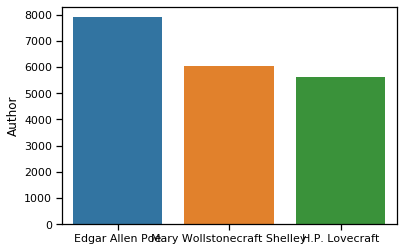

In [7]:
# Barplot of occurances of each author in the training dataset
sns.barplot(x=['Edgar Allen Poe', 'Mary Wollstonecraft Shelley', 'H.P. Lovecraft'], y=train['Author'].value_counts())
plt.show()


Edgar Allen Poe is the most frequently occuring author in the training dataset with 7900 occurances. Then it's Mary Wollstonecraft Shelley followed by H.P. Lovecraft with 6044 and 5635 occurances respectively. While there are more occurances of EAP than HPL and MWS there is still a good amount of data labeled with HPL and MWS so the small data imbalance shouldn't impact learning too much.

### Create Spooky Wordcloud

Font Credit: http://www.fontspace.com/david-shetterly/double-feature

To get the spooky font I encoded the font file in another python script using base64 library into an ASCII string format. The code for this is in the first hidden cell below. Then we can copy the encoded string into this notebook and decoded it into a newly created font file. This is in the next two hidden code cells.

In [10]:
# DO NOT RUN THIS CODE IN KERNEL
# This should be run on local machine with 'DoubleFeature21.ttf' file located in the same directory as this code
# font = open('DoubleFeature21.ttf', 'rb') # open binary file in read mode
# font_read = font.read()
# font_64_encode = base64.encodebytes(font_read)
# print(font_64_encode)  # print the encoded string to be copied into this Kaggle Kernel

In [11]:
# Combine all training text into one large string
all_text = ' '.join([text for text in train['Text']])
print('Number of words in all_text:', len(all_text))

Number of words in all_text: 2937973


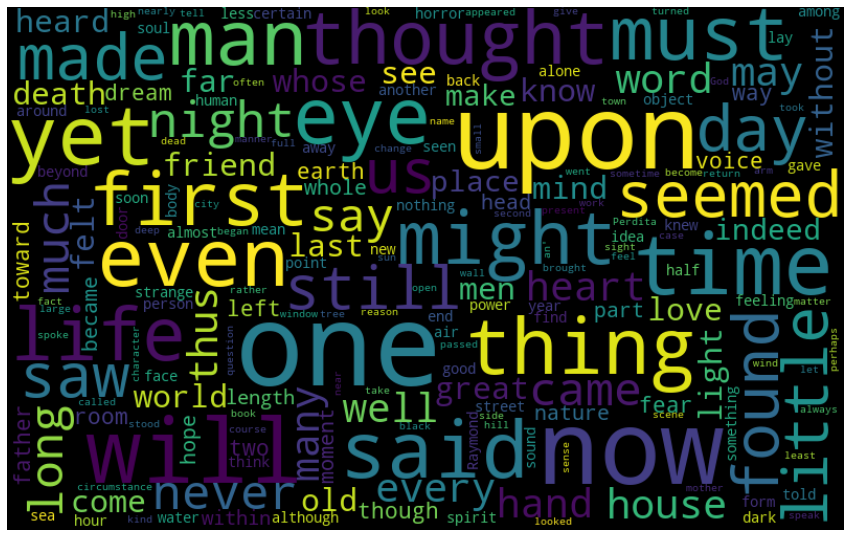

In [13]:
# Word cloud for entire training dataset
# default width=400, height=200
wordcloud = WordCloud(width=800, height=500,
                      random_state=21, max_font_size=110).generate(all_text)
plt.figure(figsize=(15, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [14]:
# Grab all text that is written by Edgar Allen Poe
eap = train[train['Author'] == 'EAP']
eap_text = ' '.join(text for text in eap['Text'])
print('Number of words in eap_text:', len(eap_text))

Number of words in eap_text: 1131484


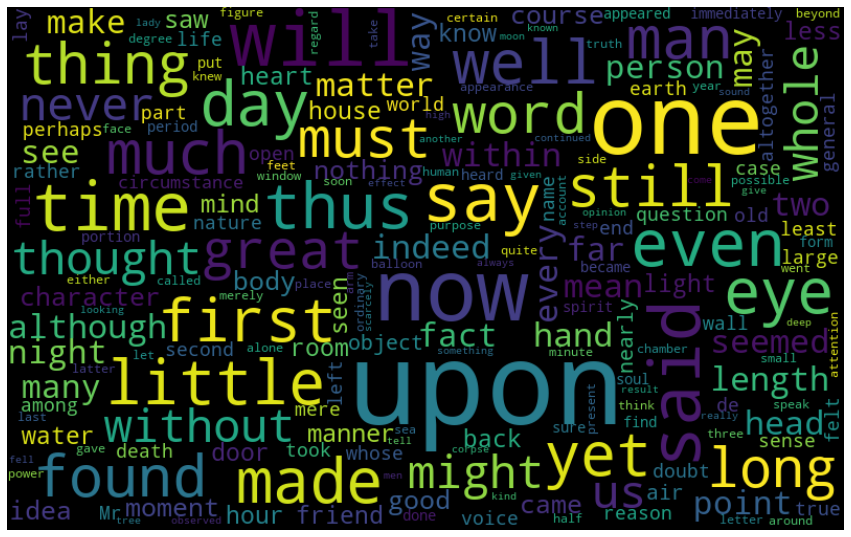

In [15]:
# Word cloud for entire training dataset
# default width=400, height=200
wordcloud = WordCloud(width=800, height=500,
                      random_state=21, max_font_size=110).generate(eap_text)
plt.figure(figsize=(15, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Wordcloud for Mary Wollstonecraft Shelley

In [16]:
# Grab all text that is written by Mary Wollstonecraft Shelley
mws = train[train['Author'] == 'MWS']
mws_text = ' '.join(text for text in mws['Text'])
print('Number of words in eap_text:', len(mws_text))

Number of words in eap_text: 922675


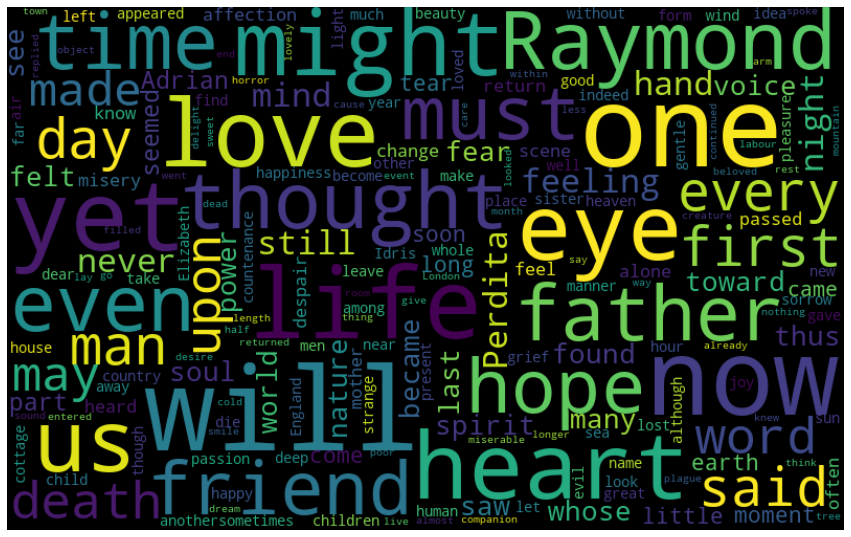

In [17]:
# Word cloud for entire training dataset
# default width=400, height=200
wordcloud = WordCloud( width=800, height=500,
                      random_state=21, max_font_size=110).generate(mws_text)
plt.figure(figsize=(15, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Wordcloud for H.P. Lovecraft¶

In [19]:
# Grab all text that is written by H.P. Lovecraft
hpl = train[train['Author'] == 'HPL']
hpl_text = ' '.join(text for text in hpl['Text'])
print('Number of words in eap_text:', len(hpl_text))


Number of words in eap_text: 883812


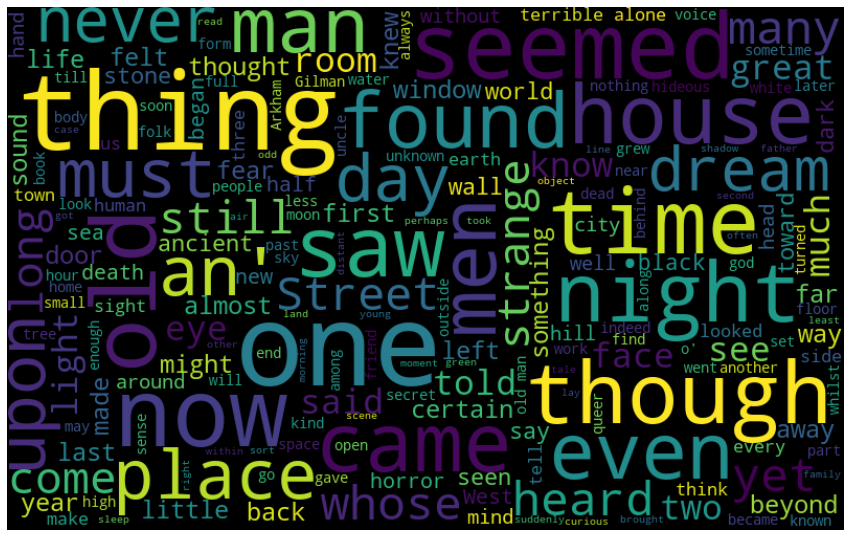

In [20]:
# Word cloud for H.P. Lovecraft
# default width=400, height=200
wordcloud = WordCloud( width=800, height=500,
                      random_state=21, max_font_size=110).generate(hpl_text)
plt.figure(figsize=(15, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Text Preprocessing with spaCy

In [21]:
import spacy

nlp = spacy.load('en_core_web_sm')

First we clean up the text by lemmatizing the words and removing personal pronouns (in spaCy the lemmatized string of personal pronouns is '-PRON-'), stopwords, and punctuations.

In [22]:
# Clean text before feeding it to spaCy
punctuations = string.punctuation

# Define function to cleanup text by removing personal pronouns, stopwords, and puncuation
def cleanup_text(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

##### Plot most frequently occuring words for each author

1.Grab all the words for each author and put them all in a list (eap_text, hpl_text, mws_text).

2.Clean the text using cleanup_text funtion. It removes stopwords, punctuation, and makes all words lowercase.

3.Remove 's from all text because spaCy doesn't remove this contraction when lemmatizing words for some reason.

4.Count occurances of all words and plot 25 most common words for each author using seaborn (also use a spooky style).

In [23]:
# Grab all text associated with Edgar Allen Poe
eap_text = [text for text in train[train['Author'] == 'EAP']['Text']]

# Grab all text associated with H.P. Lovecraft
hpl_text = [text for text in train[train['Author'] == 'HPL']['Text']]

# Grab all text associated with Mary Wollstonecraft Shelley
mws_text = [text for text in train[train['Author'] == 'MWS']['Text']]

# Clean up all text
eap_clean = cleanup_text(eap_text)
eap_clean = ' '.join(eap_clean).split()
# 's appears a lot in the text, so we get rid of it since it's not a word
eap_clean = [word for word in eap_clean if word != '\'s']

hpl_clean = cleanup_text(hpl_text)
hpl_clean = ' '.join(hpl_clean).split()
# 's appears a lot in the text, so we get rid of it since it's not a word
hpl_clean = [word for word in hpl_clean if word != '\'s']

mws_clean = cleanup_text(mws_text)
mws_clean = ' '.join(mws_clean).split()
# 's appears a lot in the text, so we get rid of it since it's not a word
mws_clean = [word for word in mws_clean if word != '\'s']

# Count all unique words
eap_counts = Counter(eap_clean)
hpl_counts = Counter(hpl_clean)
mws_counts = Counter(mws_clean)

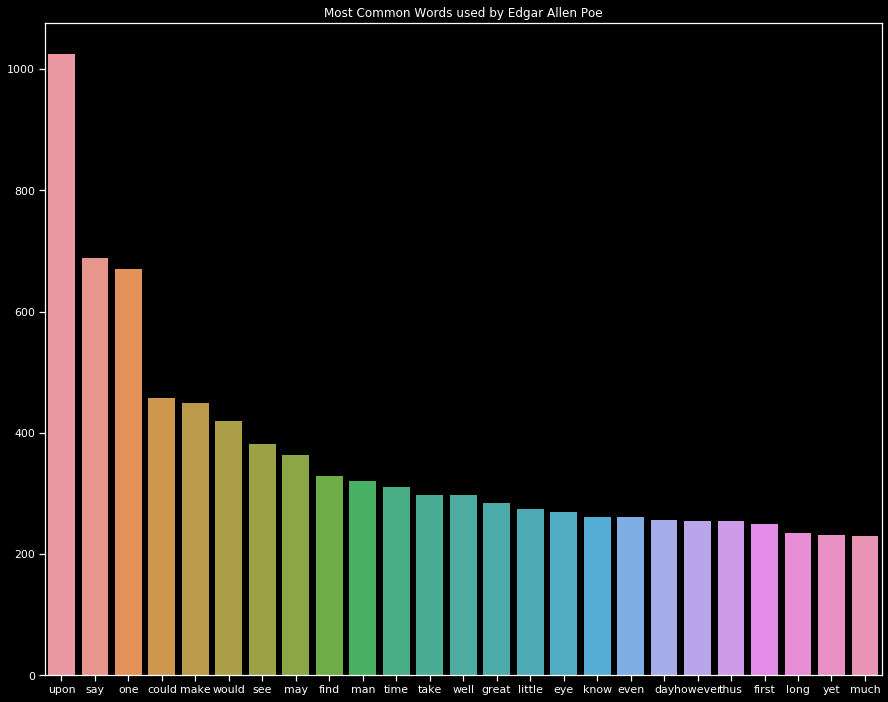

In [24]:
# Plot top 25 most frequently occuring words for Edgar Allen Poe
eap_common_words = [word[0] for word in eap_counts.most_common(25)]
eap_common_counts = [word[1] for word in eap_counts.most_common(25)]

# Use spooky background
plt.style.use('dark_background')
plt.figure(figsize=(15, 12))

sns.barplot(x=eap_common_words, y=eap_common_counts)
plt.title('Most Common Words used by Edgar Allen Poe')
plt.show()

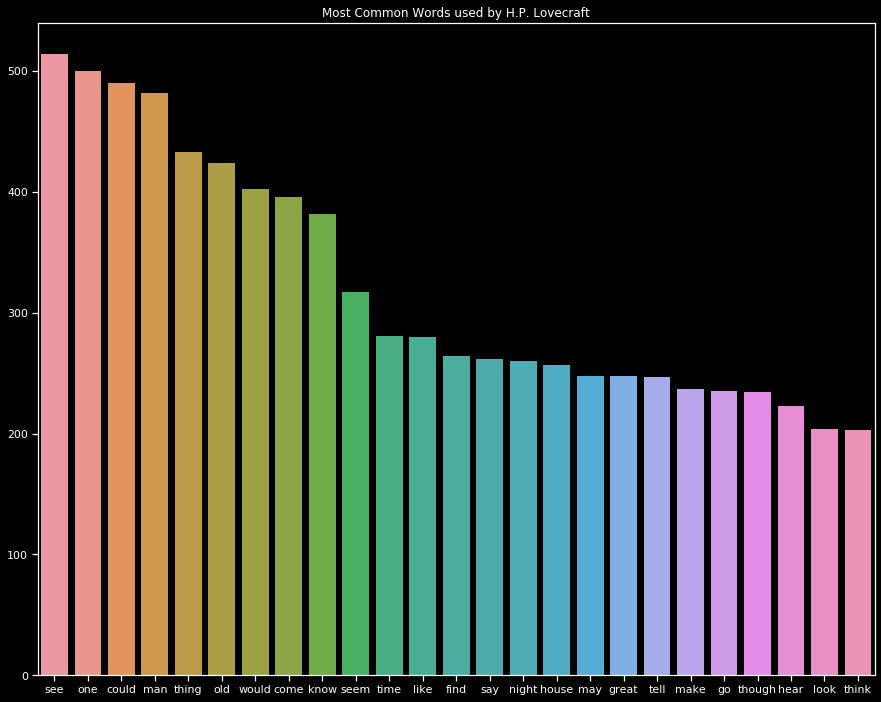

In [25]:
# Plot top 25 most frequently occuring words for H.P. Lovecraft
hpl_common_words = [word[0] for word in hpl_counts.most_common(25)]
hpl_common_counts = [word[1] for word in hpl_counts.most_common(25)]

plt.figure(figsize=(15, 12))
sns.barplot(x=hpl_common_words, y=hpl_common_counts)
plt.title('Most Common Words used by H.P. Lovecraft')
plt.show()

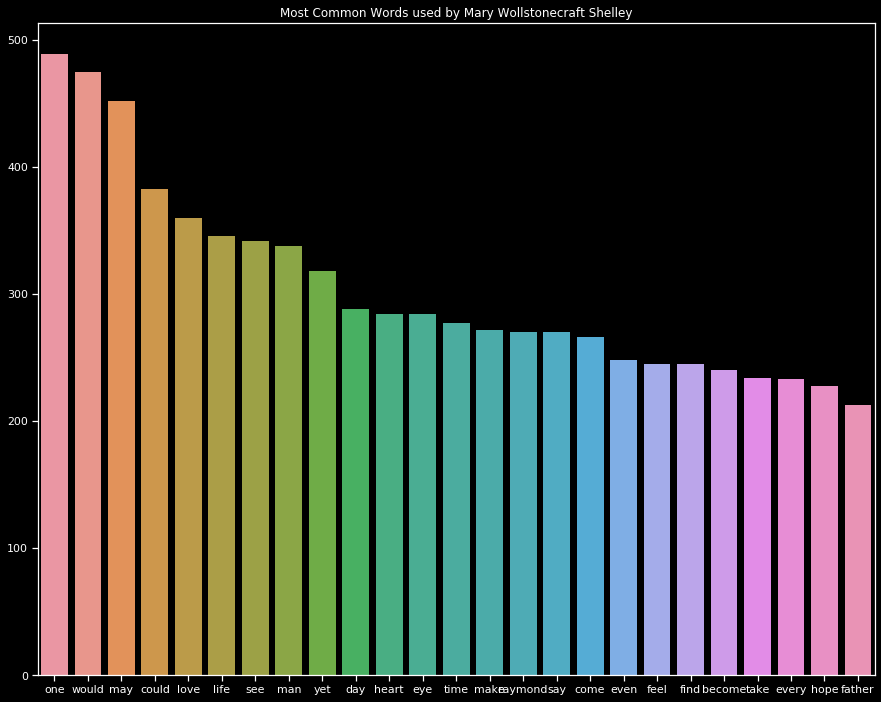

In [26]:
# Plot top 25 most frequently occuring words for Mary Wollstonecraft Shelley
mws_common_words = [word[0] for word in mws_counts.most_common(25)]
mws_common_counts = [word[1] for word in mws_counts.most_common(25)]

plt.figure(figsize=(15, 12))
sns.barplot(x=mws_common_words, y=mws_common_counts)
plt.title('Most Common Words used by Mary Wollstonecraft Shelley')
plt.show()

In [27]:
# See count list of all words
print(eap_counts.most_common(25))
print()
print(hpl_counts.most_common(25))
print()
print(mws_counts.most_common(25))

[('upon', 1025), ('say', 688), ('one', 671), ('could', 458), ('make', 450), ('would', 420), ('see', 381), ('may', 364), ('find', 328), ('man', 321), ('time', 311), ('take', 298), ('well', 298), ('great', 284), ('little', 275), ('eye', 270), ('know', 261), ('even', 261), ('day', 257), ('however', 254), ('thus', 254), ('first', 249), ('long', 234), ('yet', 232), ('much', 230)]

[('see', 514), ('one', 500), ('could', 490), ('man', 482), ('thing', 433), ('old', 424), ('would', 402), ('come', 396), ('know', 382), ('seem', 317), ('time', 281), ('like', 280), ('find', 264), ('say', 262), ('night', 260), ('house', 257), ('may', 248), ('great', 248), ('tell', 247), ('make', 237), ('go', 235), ('though', 234), ('hear', 223), ('look', 204), ('think', 203)]

[('one', 489), ('would', 475), ('may', 452), ('could', 383), ('love', 360), ('life', 346), ('see', 342), ('man', 338), ('yet', 318), ('day', 288), ('heart', 284), ('eye', 284), ('time', 277), ('make', 272), ('raymond', 270), ('say', 270), ('co

In [28]:
# Cleanup text and make sure it retains original shape
print('Original training data shape: ', train['Text'].shape)
train_cleaned = cleanup_text(train['Text'], logging=True)
print('Cleaned up training data shape: ', train_cleaned.shape)

Original training data shape:  (19579,)
Processed 1000 out of 19579 documents.
Processed 2000 out of 19579 documents.
Processed 3000 out of 19579 documents.
Processed 4000 out of 19579 documents.
Processed 5000 out of 19579 documents.
Processed 6000 out of 19579 documents.
Processed 7000 out of 19579 documents.
Processed 8000 out of 19579 documents.
Processed 9000 out of 19579 documents.
Processed 10000 out of 19579 documents.
Processed 11000 out of 19579 documents.
Processed 12000 out of 19579 documents.
Processed 13000 out of 19579 documents.
Processed 14000 out of 19579 documents.
Processed 15000 out of 19579 documents.
Processed 16000 out of 19579 documents.
Processed 17000 out of 19579 documents.
Processed 18000 out of 19579 documents.
Processed 19000 out of 19579 documents.
Cleaned up training data shape:  (19579,)


Something I noticed in this new version of spaCy is that with that smaller english models there are some instances where there are no word vectors available. After cleaning the text there are some instances where there are no vectors available. The text with the following indices have no vector meaning their attribute "has_vector" is false: 477, 1023, 3601, 8654, and 9163. It also messes with our final vector shape so to fix this if a text has no vector then we will fill it with zeros. This is a quick and dirty fix until Kaggle supports an enligh model that has the GloVe vectors (en_core_web_md, en_core_web_lg, en_vectors_web_lg).

In [31]:
# Parse documents and print some info
print('Parsing documents...')

start = time()

train_vec = []
for doc in nlp.pipe(train_cleaned, batch_size=500):
    if doc.has_vector:
        train_vec.append(doc.vector)
    # If doc doesn't have a vector, then fill it with zeros.
    else:
        train_vec.append(np.zeros((128,), dtype="float32"))
        
# train_vec = [doc.vector for doc in nlp.pipe(train_cleaned, batch_size=500)]
train_vec = np.array(train_vec)

end = time()
print('Total time passed parsing documents: {} seconds'.format(end - start))
print('Total number of documents parsed: {}'.format(len(train_vec)))
print('Number of words in first document: ', len(train['Text'][0]))
print('Number of words in second document: ', len(train['Text'][1]))
print('Size of vector embeddings: ', train_vec.shape[1])
print('Shape of vectors embeddings matrix: ', train_vec.shape)

Parsing documents...
Total time passed parsing documents: 42.81691312789917 seconds
Total number of documents parsed: 19579
Number of words in first document:  231
Number of words in second document:  71


IndexError: tuple index out of range

Now that we created train_vec we are ready to feed it into a deep learning model. You can skip down to the section titled "One-Hot Encode Labels." The next section tries a different approach to creating word vectors by using Word2Vec.

###   Alternate Approach using Word2Vec

Instead of simply grabbing the word vectors using spacy, let's try training a word2vec model on all our text and creating custom word embeddings from that model. Word2Vec also benefits from having stopwords because they give context to the sentences. Therefore we will instead modify our above function "cleanup_text" and create a new function called "cleanup_text_word2vec" to not remove stopwords as well as include personal pronouns. Word2Vec expects a list of sentences where the sentences are lists of words so we will modify the function to do that as well.`

In [32]:
# First combine train and test text into one dataframe to make parsing text easier
all_text = np.concatenate((train['Text'], test['Text']), axis=0)
all_text = pd.DataFrame(all_text, columns=['Text'])
print('Number of total text documents:', len(all_text))

Number of total text documents: 27971


In [33]:
# Define function to preprocess text for a word2vec model
def cleanup_text_word2vec(docs, logging=False):
    sentences = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents" % (counter, len(docs)))
        # Disable tagger so that lemma_ of personal pronouns (I, me, etc) don't getted marked as "-PRON-"
        doc = nlp(doc, disable=['tagger'])
        # Grab lemmatized form of words and make lowercase
        doc = " ".join([tok.lemma_.lower() for tok in doc])
        # Split into sentences based on punctuation
        doc = re.split("[\.?!;] ", doc)
        # Remove commas, periods, and other punctuation (mostly commas)
        doc = [re.sub("[\.,;:!?]", "", sent) for sent in doc]
        # Split into words
        doc = [sent.split() for sent in doc]
        sentences += doc
        counter += 1
    return sentences

In [34]:
train_cleaned_word2vec = cleanup_text_word2vec(all_text['Text'], logging=True)
print('Cleaned up training data size (i.e. number of sentences): ', len(train_cleaned_word2vec))

Processed 1000 out of 27971 documents
Processed 2000 out of 27971 documents
Processed 3000 out of 27971 documents
Processed 4000 out of 27971 documents
Processed 5000 out of 27971 documents
Processed 6000 out of 27971 documents
Processed 7000 out of 27971 documents
Processed 8000 out of 27971 documents
Processed 9000 out of 27971 documents
Processed 10000 out of 27971 documents
Processed 11000 out of 27971 documents
Processed 12000 out of 27971 documents
Processed 13000 out of 27971 documents
Processed 14000 out of 27971 documents
Processed 15000 out of 27971 documents
Processed 16000 out of 27971 documents
Processed 17000 out of 27971 documents
Processed 18000 out of 27971 documents
Processed 19000 out of 27971 documents
Processed 20000 out of 27971 documents
Processed 21000 out of 27971 documents
Processed 22000 out of 27971 documents
Processed 23000 out of 27971 documents
Processed 24000 out of 27971 documents
Processed 25000 out of 27971 documents
Processed 26000 out of 27971 docum

Now we can create our Word2Vec model and train it using our sentences. Here we define the parameters for Word2Vec:

size: Word vector dimensionality size is 300

window: Maximum distance between center word and predicted word in a sentence

min_count: Ignore all words that appear with less frequency than this

workers: Use this many workers to train model. Leads to faster training on multi-core machines

sg: Define archetecture. 1 for skip-gram, 0 for continouous bag of words (CBOW).
   
   CBOW is faster but skip-gram gives better performance

In [35]:
from gensim.models.word2vec import Word2Vec

text_dim = 300
print("Training Word2Vec model...")
wordvec_model = Word2Vec(train_cleaned_word2vec, size=text_dim, window=5, min_count=3, workers=4, sg=1)
print("Word2Vec model created.")
print("%d unique words represented by %d dimensional vectors" % (len(wordvec_model.wv.vocab), text_dim))

Training Word2Vec model...
Word2Vec model created.
10768 unique words represented by 300 dimensional vectors


Now that we trained our model we can use some built-in functions to evaluate our model. However just because this may or may not give good answers doesn't necessarily mean it will give a good performance on our end application. Either way it is useful to see the semantic relationships the model has learned.

In [36]:
print(wordvec_model.wv.most_similar(positive=['woman', 'king'], negative=['man']))
print(wordvec_model.wv.most_similar_cosmul(positive=['woman', 'king'], negative=['man']))
print(wordvec_model.wv.doesnt_match("breakfast cereal dinner lunch".split()))
print(wordvec_model.wv.similarity('woman', 'man'))
print(wordvec_model.wv.similarity('gruesome', 'terrify'))

[('young', 0.8290104866027832), ('son', 0.813653290271759), ('eldest', 0.8100823163986206), ('favourite', 0.8012856245040894), ('daughter', 0.7999005317687988), ('queen', 0.79075026512146), ('widow', 0.78682541847229), ('infant', 0.7862571477890015), ('poor', 0.7823325395584106), ('birth', 0.7803756594657898)]
[('young', 1.0552963018417358), ('daughter', 1.047382116317749), ('son', 1.043378233909607), ('eldest', 1.040859341621399), ('favourite', 1.038314700126648), ('birth', 1.0313751697540283), ('widow', 1.0286635160446167), ('queen', 1.0278123617172241), ('infant', 1.022778868675232), ('poor', 1.0201475620269775)]
dinner
0.73338723
0.837312


We no longer need train_cleaned_word2vec anymore because that was only for training the Word2Vec model. Now we can use the original train_cleaned variable that removed stopwords. The Word2Vec model can give us a 300 dimensional vector for individual words so we need a way to represent a text example that has multiple words in it in just 300 dimensions. One way of doing that is to average the word vectors for each word in a text example.

For intance (first training text cleaned): process afford mean ascertain dimension dungeon make circuit return point set aware fact perfectly uniform wall

We need to add up the word vectors for each word (process + afford + mean + ...) and divide by the number of words in this example (16). But if there is no word vector in our model for a given word then we ignore it.

In [37]:
# Define function to create word vectors given a cleaned piece of text.
def create_average_vec(doc):
    average = np.zeros((text_dim,), dtype='float32')
    num_words = 0.
    for word in doc.split():
        if word in wordvec_model.wv.vocab:
            average = np.add(average, wordvec_model[word])
            num_words += 1.
    if num_words != 0.:
        average = np.divide(average, num_words)
    return average

Here we run into a problem. After cleaning up the text there are some text pieces that end up having no words in them at all! This means that the entire text is composed of stopwords. Here is an example:

train['Text'][477] = 'After all, what is it?'

After lemmatizing each word with spaCy, every word is part of nltk's stopword list and get completely cleaned out by our cleanup_text function. Also when we try to use the create_average_vec function on a text example with no words in it then we just get a 300 dimensional vector of zeros. Fortunately this only occurs 5 times in the text so for now we will ignore it and see how well our model performs but in the future we may want to find a way to better represent text filled with stopwords.

In [39]:
# Counting the number of empty strings are in train_cleaned
count = 0
for i in range(len(train_cleaned)):
    if train_cleaned[i] == "":
        print("index:", i)
        count += 1
print(count)

index: 477
index: 1023
index: 3601
index: 8654
4


In [40]:
# Create word vectors
train_cleaned_vec = np.zeros((train.shape[0], text_dim), dtype="float32")  # 19579 x 300
for i in range(len(train_cleaned)):
    train_cleaned_vec[i] = create_average_vec(train_cleaned[i])

print("Train word vector shape:", train_cleaned_vec.shape)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


Train word vector shape: (19579, 300)


### One-Hot Encode Labels

Now we should one hoe encode the labels. We can do so using sci-kit learn's label_binarize function



In [41]:
from sklearn.preprocessing import label_binarize

# Transform labels into one hot encoded format.
y_train_ohe = label_binarize(train['Author'], classes=['EAP', 'HPL', 'MWS'])
print('y_train_ohe shape: {}'.format(y_train_ohe.shape))
print('y_train_ohe samples:')
print(y_train_ohe[:5])

y_train_ohe shape: (19579, 3)
y_train_ohe samples:
[[1 0 0]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]]


#### Split into Train/Test Datasets
To avoid building a model that performs well ONLY on the test set we carve out a new train/test set using the training set provided by Kaggle. This way we can do parameter tuning, try different preprocessing methods, etc and calculate a log loss score without submitting to Kaggle. Now we don't have to worry about building a model that performs well for the Kaggle-provided test set but doesn't generalize to new examples.

In [42]:
from sklearn.model_selection import train_test_split

# If using spaCy word vectors
# X_train, X_test, y_train, y_test = train_test_split(train_vec, y_train_ohe, test_size=0.2, random_state=21)
# If using Word2Vec word vectors
X_train, X_test, y_train, y_test = train_test_split(train_cleaned_vec, y_train_ohe, test_size=0.2, random_state=21)

print('X_train size: {}'.format(X_train.shape))
print('X_test size: {}'.format(X_test.shape))
print('y_train size: {}'.format(y_train.shape))
print('y_test size: {}'.format(y_test.shape))

X_train size: (15663, 300)
X_test size: (3916, 300)
y_train size: (15663, 3)
y_test size: (3916, 3)


### Deep Learning with Keras

Here we define our neural network using keras which is a deep learning python library. The architecture below is a multilayer perceptron with four hidden layers, relu activation function, and he normal kernel initialization. We also include four dropout layers to avoid overfitting.



In [43]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, LSTM, Embedding, Bidirectional, Flatten
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.optimizers import SGD

def build_model(architecture='mlp'):
    model = Sequential()
    if architecture == 'mlp':
        # Densely Connected Neural Network (Multi-Layer Perceptron)
        model.add(Dense(512, activation='relu', kernel_initializer='he_normal', input_dim=300))
        model.add(Dropout(0.2))
        model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
        model.add(Dropout(0.2))
        model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
        model.add(Dropout(0.2))
        model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
        model.add(Dropout(0.2))
        model.add(Dense(3, activation='softmax'))
    elif architecture == 'cnn':
        # 1-D Convolutional Neural Network
        inputs = Input(shape=(300,1))

        x = Conv1D(64, 3, strides=1, padding='same', activation='relu')(inputs)

        #Cuts the size of the output in half, maxing over every 2 inputs
        x = MaxPooling1D(pool_size=2)(x)
        x = Conv1D(128, 3, strides=1, padding='same', activation='relu')(x)
        x = GlobalMaxPooling1D()(x) 
        outputs = Dense(3, activation='softmax')(x)

        model = Model(inputs=inputs, outputs=outputs, name='CNN')
    elif architecture == 'lstm':
        # LSTM network
        inputs = Input(shape=(300,1))

        x = Bidirectional(LSTM(64, return_sequences=True),
                          merge_mode='concat')(inputs)
        x = Dropout(0.2)(x)
        x = Flatten()(x)
        outputs = Dense(3, activation='softmax')(x)

        model = Model(inputs=inputs, outputs=outputs, name='LSTM')
    else:
        print('Error: Model type not found.')
    return model

Using TensorFlow backend.


In [44]:
# Define keras model
# Using MLP in kernel for speed
model = build_model('mlp')
# model = build_model('cnn')
# model = build_model('lstm')

# If the model is a CNN then expand the dimensions of the training data
if model.name == "CNN" or model.name == "LSTM":
    X_train = np.expand_dims(X_train, axis=2)
    X_test = np.expand_dims(X_test, axis=2)
    print('Text train shape: ', X_test.shape)
    print('Text test shape: ', X_test.shape)
    
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               154112    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
______________________

In [45]:
# Compile the model
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['acc'])

Now we train the model on our train/test set and also include change the parameter 'val_split' to 0.2 which takes 20% of the training data and turns it into a validation set.

In [46]:
# Define number of epochs
epochs = 50

# Fit the model to the training data
estimator = model.fit(X_train, y_train,
                      validation_split=0.2,
                      epochs=epochs, batch_size=128, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 12530 samples, validate on 3133 samples
Epoch 1/50
12530/12530 [==============================] - 11s 863us/step - loss: 0.9452 - acc: 0.5430 - val_loss: 0.7402 - val_acc: 0.6834
Epoch 2/50
12530/12530 [==============================] - 6s 498us/step - loss: 0.7368 - acc: 0.6858 - val_loss: 0.7023 - val_acc: 0.7143
Epoch 3/50
12530/12530 [==============================] - 7s 542us/step - loss: 0.6972 - acc: 0.7125 - val_loss: 0.6773 - val_acc: 0.7229
Epoch 4/50
12530/12530 [==============================] - 7s 520us/step - loss: 0.6824 - acc: 0.7209 - val_loss: 0.6761 - val_acc: 0.7245
Epoch 5/50
12530/12530 [==============================] - 6s 517us/step - loss: 0.6690 - acc: 0.7227 - val_loss: 0.6601 - val_acc: 0.7357
Epoch 6/50
12530/12530 [==============================] - 6s 456us/step - loss: 0.6706 - acc: 0.7243 - val_loss: 0.6588 - val_acc: 0.7322
Epoch 7/50
12530/12530 [====

In [47]:
print("Training accuracy: %.2f%% / Validation accuracy: %.2f%%" % 
      (100*estimator.history['acc'][-1], 100*estimator.history['val_acc'][-1]))

Training accuracy: 76.54% / Validation accuracy: 74.82%


Now we can plot the model's accuracy and loss over epochs

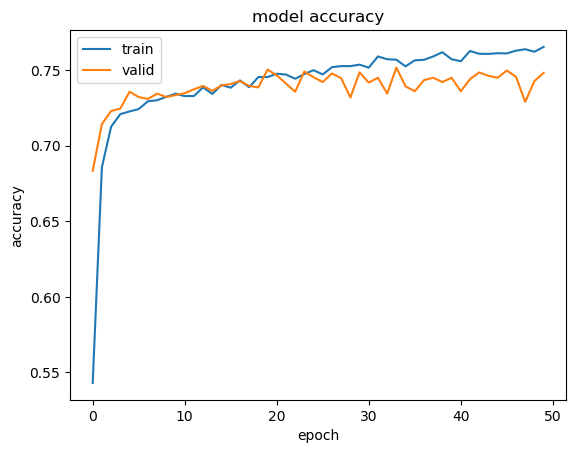

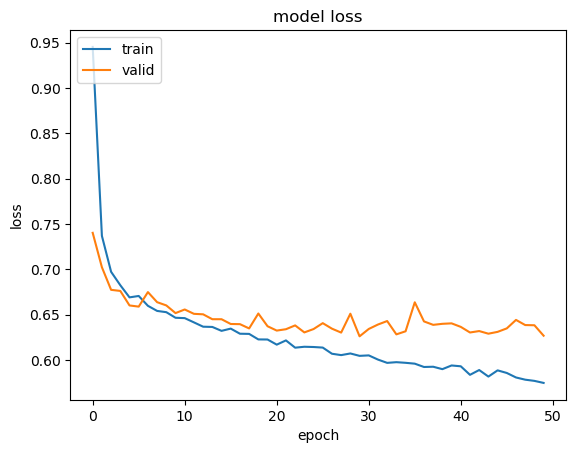

In [48]:
sns.reset_orig()   # Reset seaborn settings to get rid of black background
plt.plot(estimator.history['acc'])
plt.plot(estimator.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# Plot model loss over epochs
plt.plot(estimator.history['loss'])
plt.plot(estimator.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

#### Using spaCy word vectors


For MLP architecture: From the plot above we can see the model starts to overfit the training data early around the fifth epoch. The validation accuracy stays stable for the rest of the training and the loss goes up as training goes on.

For CNN architecture: Both the training and validation accuracy go up as training goes on. The loss also goes down continuously. With more epochs the loss would probably continue to go down until eventually saturating. Some more parameter tweaking and could also lead to a lower log loss score.

For LSTM architecture: The training accuracy is 58.90% and the validation accuracy is 58.60%. From the model accuracy plot above we can see both accuracies rise and continue to rise until the final epoch. The model losses also go down continuously indicating that more epochs will lead to a better performance.

#### Using Word2Vec word vectors¶


For MLP architecture: The training and validation accuracies are bigger than previous attempts using spaCy's built-in word vectors. The log loss also goes down further but near the end the validation loss looks like it isn't going any lower while the training loss goes lower. It seems like training over more epochs will lead to overfitting. The training accuracy is 76.26% and the validation accuracy is 74.08%.

For CNN architecture: The training and validation accuracies (72.64%, 70.89% respectively) are smaller than the MLP architecture. It also looks like the loss isn't going to go any lower with more epochs. Hyperparameter tuning and adding more layers may help to increase the accuracies and lower the loss.

For LSTM architecture: The training and validation accuracies are smaller than the CNN and MLP architectures, but higher than the LSTM accuracies without Word2Vec. Training accuracy was 70.91% and validation accuracy was 69.81%. Looking at the plot above the validation loss starts to even out so more epochs likely won't improve performance.

Now it's time to make predictions!

In [49]:
# Make predictions
predicted_prob = model.predict(X_test)
print(predicted_prob.shape)

(3916, 3)


In [50]:
# Save submission file
with open('submission.csv', 'w') as file_obj:
    file_obj.write('ID,EAP,HPL,MWS\n')
    for pred in range(len(predicted_prob)):
        file_obj.write(str(pred+1) + ',' + ','.join('{:.2f}'.format(s) for s in predicted_prob[pred].tolist()) + '\n')

In [51]:
# Report log loss and score
loss_sk = log_loss(y_test, predicted_prob)
print('Log loss is: {}'.format(loss_sk))


Log loss is: 0.6054781134621235


#### Using spaCy word vectors

The log loss for the MLP architecture is about 1.1416 which is not too bad, but can definitely be improved with parameter tweaking (number of neurons, number of layers, kernel initialization, dropout rate, etc.).

Meanwhile the log loss for the CNN architecture is about 0.952 and is an improvement over the basic MLP architecture. Again, parameter tweaking will probably lead to better results and although CNNs perform well on computer vision problems they also have a lot of uses in natural language processing.

However a lot of times recurrent neural networks (RNN), in particular long short term memory (LSTM), produce the best results. Using a LSTM architecture, the model acheived a log loss score of 0.9303. This is the best score out of all three architectures. This was also using only one hidden layer which was a bidirectional lstm layer with 64 memory units. Adding more memory units and layers and tweaking the dropout rate will probably lead to better results. Increasing the number of epochs will also lead to better results however it will increase the training time.

#### Using Word2Vec word vectors

The log loss using a MLP architecture is 0.60657. Using Word2Vec to create the word vectors greatly improved performance. I did not change any of the hyperparameters for the MLP neural net, I used the same one I used when using spaCy word vectors. Even with some text examples having all zero word vectors (because filtering out stopwords left an empty string) it seemed to work well.

The log loss using a CNN architecture is 0.68087. While it is smaller than the CNN architecture without Word2Vec, it is a little higher than the MLP architecture above. Hyperparameter tuning and possibly adding more hidden layers could help increase performance.

The log loss using a LSTM architecture is 0.711138. This is the highest log loss out of all our architectures using Word2Vec word vectors. This is surprising since LSTM gave us the best performance when using spaCy's built-in word vectors. One reason could be that the MLP is "deeper" than the LSTM. Our MLP has 4 hidden layers while the LSTM one has only 1 (with a bidirectional wrapper). Something that I will try soon is to increase the layers of our LSTM model and see if that can improve performance, although I think I will get rid of the bidirectional wrapper because I noticed it trains slightly faster without it.

	spaCy Word Vectors (GloVe)	Word2Vec

MLP	 1.1416	                    0.60657

CNN	 0.952	                    0.68087.

LSTM 0.9303                     0.711138

Here are some useful links to learn more about neural networks and their uses for natural language processing:

Primer on nerual networks and NLP: https://arxiv.org/abs/1510.00726

Understanding LSTM networks: http://colah.github.io/posts/2015-08-Understanding-LSTMs/

#### Future Works
Adding more layers to LSTM and training it

Add more text descriptions explaining neural network models and current hyperparameter settings

Trying CBOW algorithm for Word2Vec instead of skip-gram. Also try changing some other Word2Vec-related hyperparameters

Tweaking NN parameters (number of layers, kernel init, dropout rate)

Keep checking back, I'll update the kernel to try some new things.